In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')

In [4]:
print("Customers Dataset:")
display(customers.head())

print("Products Dataset:")
display(products.head())

print("Transactions Dataset:")
display(transactions.head())

Customers Dataset:


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


Products Dataset:


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


Transactions Dataset:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


# **Customer Segmentation (Clustering)**

Setting Up and Preparing the Data

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



# Merge Customers and Transactions datasets
customer_transactions = transactions.merge(customers, on='CustomerID', how='inner')

# Aggregate customer transaction data
customer_profile = customer_transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    region=('Region', 'first')  # Assuming one region per customer
).reset_index()

# Add the most purchased product categories to the profile
category_data = transactions.merge(products, on='ProductID', how='left')
top_category = category_data.groupby(['CustomerID', 'Category'])['Quantity'].sum().reset_index()
top_category = top_category.sort_values(['CustomerID', 'Quantity'], ascending=[True, False]).drop_duplicates('CustomerID')
customer_profile = customer_profile.merge(top_category[['CustomerID', 'Category']], on='CustomerID', how='left')

print("\nCustomer Profile:")
display(customer_profile.head())



Customer Profile:


,CustomerID,total_spent,total_transactions,avg_transaction_value,region,Category
0,C0001,3354.52,5,670.904,South America,Electronics
1,C0002,1862.74,4,465.685,Asia,Home Decor
2,C0003,2725.38,4,681.345,South America,Home Decor
3,C0004,5354.88,8,669.360,South America,Home Decor
4,C0005,2034.24,3,678.080,Asia,Electronics


Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for clustering
clustering_features = customer_profile[['total_spent', 'total_transactions', 'avg_transaction_value']]

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_features)

print("Scaled Data Shape:", scaled_data.shape)


Scaled Data Shape: (199, 3)


Determine Optimal Clusters

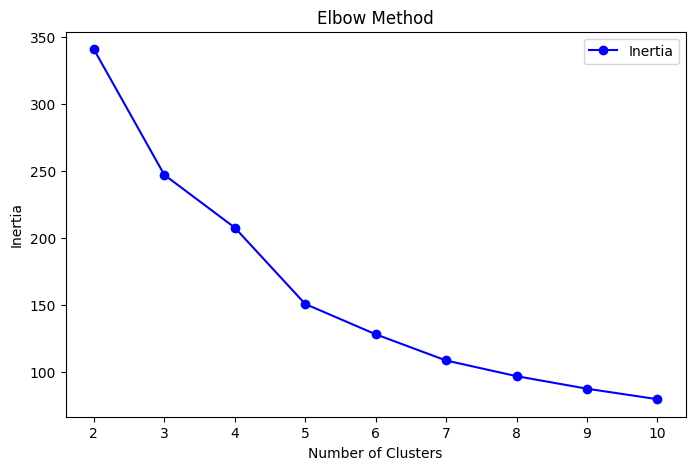

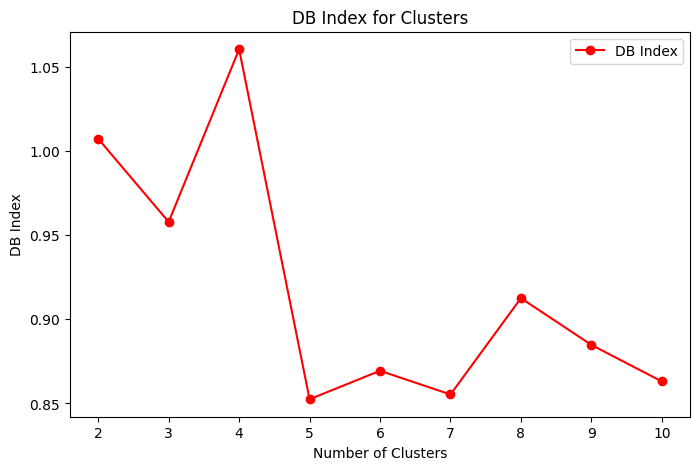

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Find the optimal number of clusters using the Elbow Method
inertia = []
db_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', color='blue', label='Inertia')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.legend()
plt.show()

# Plot DB Index
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o', color='red', label='DB Index')
plt.title("DB Index for Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.legend()
plt.show()


Apply K-Means Clustering

In [10]:
# Choose optimal clusters (e.g., 4 based on the above plots)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)

print("\nClustered Customer Profile:")
display(customer_profile.head())

# Evaluate final DB Index
final_db_index = davies_bouldin_score(scaled_data, customer_profile['Cluster'])
print(f"Final DB Index for {optimal_clusters} Clusters: {final_db_index:.3f}")



Clustered Customer Profile:


,CustomerID,total_spent,total_transactions,avg_transaction_value,region,Category,Cluster
0,C0001,3354.52,5,670.904,South America,Electronics,3
1,C0002,1862.74,4,465.685,Asia,Home Decor,1
2,C0003,2725.38,4,681.345,South America,Home Decor,3
3,C0004,5354.88,8,669.360,South America,Home Decor,0
4,C0005,2034.24,3,678.080,Asia,Electronics,3


Final DB Index for 4 Clusters: 1.060


Visualize Clusters

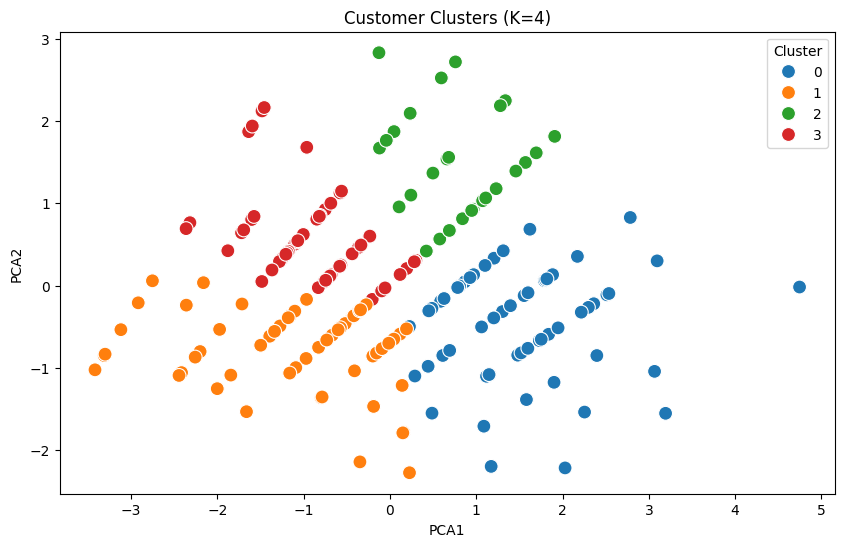

In [11]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Add PCA components to the customer profile
customer_profile['PCA1'] = reduced_data[:, 0]
customer_profile['PCA2'] = reduced_data[:, 1]

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_profile, palette='tab10', s=100
)
plt.title(f"Customer Clusters (K={optimal_clusters})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='Cluster')
plt.show()


Summarize Clustering Results

In [12]:
# Cluster-level summary
cluster_summary = customer_profile.groupby('Cluster').agg(
    avg_spent=('total_spent', 'mean'),
    avg_transactions=('total_transactions', 'mean'),
    top_region=('region', lambda x: x.value_counts().idxmax()),
    top_category=('Category', lambda x: x.value_counts().idxmax())
).reset_index()

print("\nCluster Summary:")
display(cluster_summary)



Cluster Summary:


,Cluster,avg_spent,avg_transactions,top_region,top_category
0,0,5521.543966,7.517241,South America,Clothing
1,1,2103.758333,4.583333,Europe,Home Decor
2,2,4317.132143,4.142857,Europe,Books
3,3,2313.977547,3.264151,South America,Books


In [13]:
# Save customer clusters to CSV
customer_profile.to_csv('Subramanya_Naik-Customer_Clusters.csv', index=False)

# Save cluster summary to CSV
cluster_summary.to_csv('Subramanya_Naik_Cluster_Summary.csv', index=False)

print("Clustering results saved to Customer_Clusters.csv and Cluster_Summary.csv")


Clustering results saved to Customer_Clusters.csv and Cluster_Summary.csv
